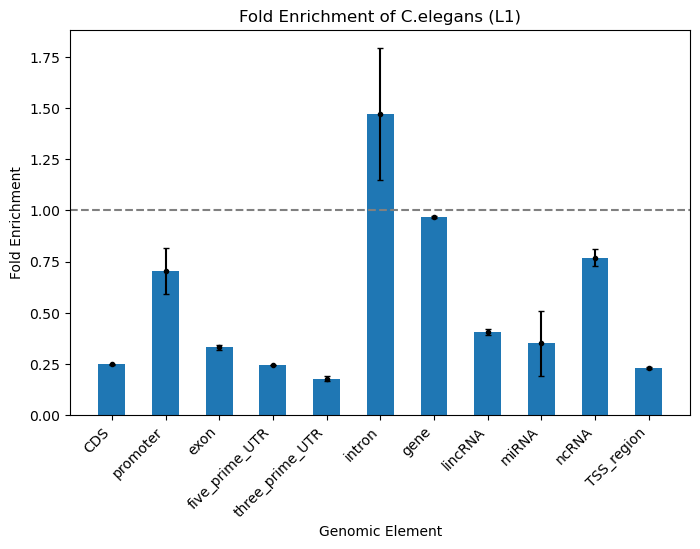

In [18]:
# imports
import gffpandas.gffpandas as gffpd
from pybedtools import BedTool 
import pybedtools
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def peaks2bed(peak_file):
    '''convert peaks file to bedtool object'''
    return BedTool(peak_file).sort()

def intersect_func(genomic_element, peaks):
    '''intersect genomic element file with observed peaks'''
    intersection = BedTool(genomic_element).sort().intersect(peaks)
    intersection_df = pd.read_table(intersection.fn, names=['seq_id', 'start', 'end'])
    num_overlaps = intersection_df.shape[0]
    return num_overlaps

def construct_genomic_df(peaks):
    '''construct df with elements and observed overlaps'''
    genomic_elements = ['c-elegans-11-CDS.bed', 'c-elegans-11-promoter.bed', 
                        'c-elegans-11-exon.bed', 'c-elegans-11-five_prime_UTR.bed', 
                    'c-elegans-11-three_prime_UTR.bed', 'c-elegans-11-intron.bed', 
                    'c-elegans-11-gene.bed', 'c-elegans-11-lincRNA.bed', 'c-elegans-11-miRNA.bed', 
                    'c-elegans-11-ncRNA.bed', 'c-elegans-11-TSS_region.bed']
    genomic_elements = [f'ce-11-beds/{name}' for name in genomic_elements]

    genomic_df = pd.DataFrame(genomic_elements, columns=['genomic element'])
    genomic_df['overlaps'] = genomic_df['genomic element'].map(lambda x: intersect_func(x, peaks))
    return genomic_df

def shuffled_intersects(element, peaks, genome_file):
    '''return intersect of an element with shuffled peaks'''
    shuffled = peaks.shuffle(g=genome_file)
    return intersect_func(element, shuffled)

def run_shuffle_intersects(df, num, peaks, genome_file):
    '''run intersects for all elements'''
    for i in range(num):
        df[f'shuffle_overlap{i+1}'] = df['genomic element'].map(lambda x: shuffled_intersects(x, peaks, genome_file))

def calc_stats(df, num):
    '''calculates mean and standard error for fold enrichment'''
    cols = list()
    for i in range(num):
        df[f'fe{i+1}'] = df['overlaps']/df[f'shuffle_overlap{i+1}']
        cols.append(f'fe{i+1}')
    df['fe_mean'] = df[cols].mean(axis=1)
    df['se'] = df[cols].sem(axis=1)

def make_fig(df):
    df['genomic element'] = df['genomic element'].str[24:-4]
    
    x = df['genomic element']
    y = df['fe_mean']
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, y, width=0.5)
    ax.set(title='Fold Enrichment of C.elegans (L1)', xlabel='Genomic Element', ylabel='Fold Enrichment')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y = 1, color = 'gray', linestyle = 'dashed') 
    ax.errorbar(x, y, yerr=df['se'], fmt='.', color="black", capsize=2)
    plt.savefig('ce11-fold-enrichment-figs/celegans_fe_L1(3).svg', bbox_inches='tight')

def main():
    p = peaks2bed('BG4_L1_HQ.bed')
    df = construct_genomic_df(p)

    num_shuffles = 3
    gf = 'ce11.genome'
    run_shuffle_intersects(df, num_shuffles, p, gf)
    calc_stats(df, 3)

    make_fig(df)


main()

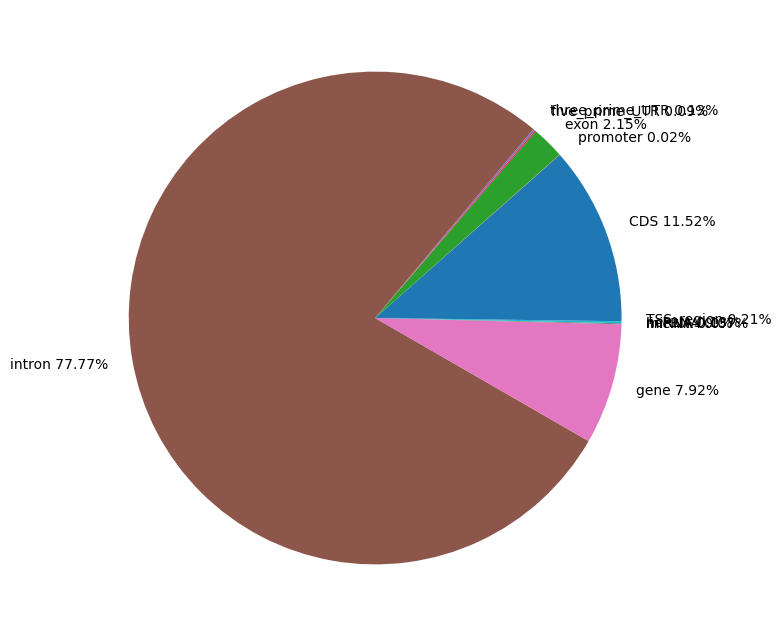

In [24]:
def make_pie(df):
    df['genomic element'] = df['genomic element'].str[24:-4]
    sizes = df['overlaps']/df['overlaps'].sum()
    labels = [x + ' ' + str(round(y*100, 2)) + '%' for x, y in zip(list(df['genomic element']), sizes)]
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels)

def main():
    p = peaks2bed('BG4_L1_HQ.bed')
    df = construct_genomic_df(p)
    make_pie(df)

main()
